In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
import PIL
from tensorflow.keras import layers , Sequential
import pathlib
import imutils
from scipy.spatial import distance as dist
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

## Reading the data

In [6]:
train_data_dir = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"

In [7]:
train_data_dir = pathlib.Path(train_data_dir)

In [8]:
image_count = len(list(train_data_dir.glob('*/*.jpeg')))
image_count

9957

In [9]:
EOSINOPHIL = list(train_data_dir.glob('EOSINOPHIL/*'))
LYMPHOCYTE = list(train_data_dir.glob('LYMPHOCYTE/*'))
MONOCYTE = list(train_data_dir.glob('MONOCYTE/*'))
NEUTROPHIL = list(train_data_dir.glob('NEUTROPHIL/*'))

## Preparing the Data and Processing

In [10]:
cell_images_dict = {
    'EOSINOPHIL' : EOSINOPHIL,
    'LYMPHOCYTE' : LYMPHOCYTE,
    'MONOCYTE' : MONOCYTE,
    'NEUTROPHIL' : NEUTROPHIL
}

In [11]:
cells_names_dict = {
    'EOSINOPHIL':0,
    'LYMPHOCYTE':1,
    'MONOCYTE':2,
    'NEUTROPHIL':3
}

In [12]:
def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [13]:
def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [14]:
def getboxes(contours,orig):
    boxes = []
    for contour in contours:
        box = cv2.minAreaRect(contour) #takes 2D pointset which is contours here and returns BOX2D structure
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)#box contains 4 corners of the rectangle
        #check the version of the opencv and apply the method then return 4 corner points
        box = np.array(box, dtype="int") #convert values to integer numbers
        (tl, tr, br, bl) = box #identify 4 corners in clock wise direction with the highest y
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [15]:
def loadImage(ImageDict):
    X_train,y_train = [] , []
    count=0
    for cell_name,imagess in ImageDict.items():
        print(cell_name,len(imagess))
        for imagee in imagess:
            img = cv2.imread(str(imagee))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])

            image1 = cv2.inRange(img,(80, 80, 180),(180, 170, 245))#thresholding to target the image

            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)#Deleting Noise
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)


            edgedImage = findedges(image1)
            edgedContours = getimageconturs(edgedImage)
            edgedBoxes =  getboxes(edgedContours, img.copy()) #got the 4 cornerns of the rectangle 


            if len(edgedBoxes)==0:
                        count +=1   #no cell to detect , no rectangle to be drawn
                        continue
                    # get the large box and get its cordinate
            last = edgedBoxes[-1] #edgedboxes = boxes list returned from getboxes def , boxes has 4 corner number of each array point
            max_x = int(max(last[:,0])) #
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))
            mask = np.zeros_like(img)

            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1)#len

                    # any pixel but the pixels inside the contour is zero
            img[mask==0] = 0

                    # extract th blood cell
            img = img[min_y:max_y, min_x:max_x]

            if (np.size(img)==0):
                count +=1
                continue
                    # resize th image
            resized_img = cv2.resize(img, (224,224))
            normall = cv2.cvtColor(resized_img,cv2.COLOR_RGB2BGR)
            X_train.append(normall)
            y_train.append(cells_names_dict[cell_name])
    return X_train,y_train

In [16]:
X,y =loadImage(cell_images_dict)

EOSINOPHIL 2497
LYMPHOCYTE 2483
MONOCYTE 2478
NEUTROPHIL 2499


In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
type(X) , type(y)

(numpy.ndarray, numpy.ndarray)

## Splitting the data (Training , validation)

In [19]:
x_train,x_test,val_train,val_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [20]:
# Shapes
print(f'X Train: {x_train.shape}')
print(f'X Test: {x_test.shape}')
print(f'Val Train: {val_train.shape}')
print(f'Val Test: {val_test.shape}')

X Train: (6804, 224, 224, 3)
X Test: (2916, 224, 224, 3)
Val Train: (6804,)
Val Test: (2916,)


In [21]:
val_train[:20]

array([1, 2, 0, 0, 2, 3, 1, 3, 1, 1, 3, 3, 1, 1, 2, 0, 2, 3, 3, 1])

## Building the model

### VGG16

In [22]:
x_train.shape

(6804, 224, 224, 3)

In [23]:
image_shape = (224,224) #(224,224,3)

In [24]:
vgg = VGG16(input_shape = image_shape+(3,) , include_top=False , weights='imagenet')

2022-12-16 22:16:02.826435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 22:16:02.827387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 22:16:03.001971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 22:16:03.002781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 22:16:03.003539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 1s 0us/step


In [25]:
for layer in vgg.layers:
    layer.trainable = False

In [26]:
x = layers.Flatten()(vgg.output) 

x = layers.Dense(200,activation='relu') (x)

outputs = layers.Dense(4,activation='softmax')(x)

model = tf.keras.models.Model(inputs=vgg.input , outputs = outputs)

In [27]:
model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

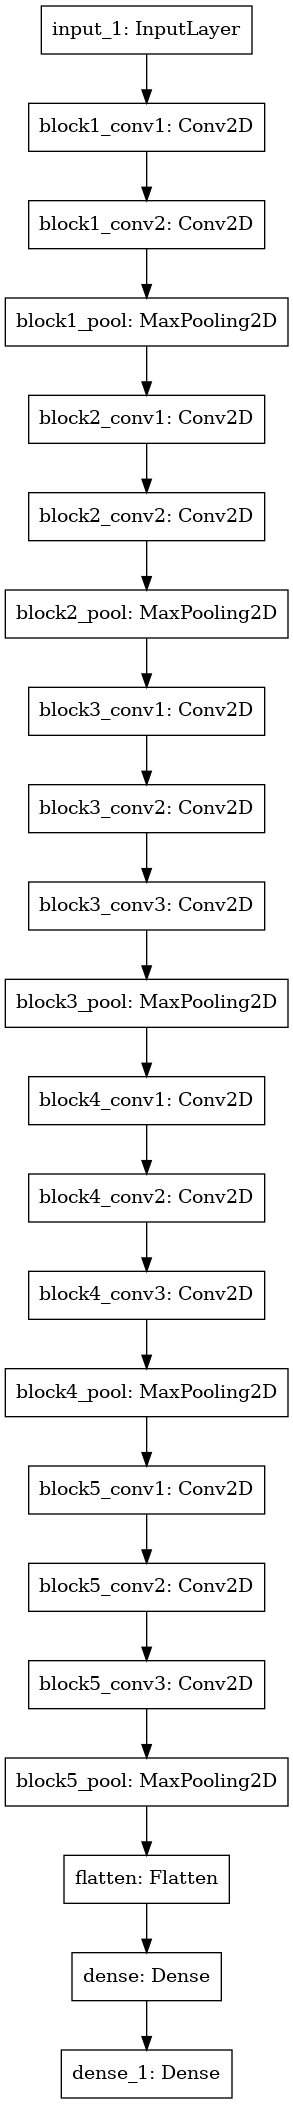

In [29]:
keras.utils.plot_model(model, "VGG16.png")

In [30]:
vgghist = model.fit(x_train,val_train,batch_size=32,epochs=15,validation_data=(x_test,val_test))

2022-12-16 22:16:08.427449: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024192512 exceeds 10% of free system memory.
2022-12-16 22:16:09.619352: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024192512 exceeds 10% of free system memory.
2022-12-16 22:16:10.481806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-16 22:16:12.876150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


213/213 [==============================] - 55s 188ms/step - loss: 3.4271 - accuracy: 0.7909 - val_loss: 0.2881 - val_accuracy: 0.8885
Epoch 2/15
213/213 [==============================] - 36s 167ms/step - loss: 0.1667 - accuracy: 0.9364 - val_loss: 0.2188 - val_accuracy: 0.9146
Epoch 3/15
213/213 [==============================] - 37s 174ms/step - loss: 0.0610 - accuracy: 0.9769 - val_loss: 0.1955 - val_accuracy: 0.9232
Epoch 4/15
213/213 [==============================] - 37s 175ms/step - loss: 0.0335 - accuracy: 0.9879 - val_loss: 0.3223 - val_accuracy: 0.8995
Epoch 5/15
213/213 [==============================] - 37s 174ms/step - loss: 0.0380 - accuracy: 0.9869 - val_loss: 0.2223 - val_accuracy: 0.9276
Epoch 6/15
213/213 [==============================] - 37s 175ms/step - loss: 0.0373 - accuracy: 0.9871 - val_loss: 0.4352 - val_accuracy: 0.8951
Epoch 7/15
213/213 [==============================] - 37s 174ms/step - loss: 0.0784 - accuracy: 0.9743 - val_loss: 0.3718 - val_accuracy: 0.9

### VGG16 Evaluation

In [31]:
model.evaluate(x_test,val_test)

92/92 [==============================] - 11s 120ms/step - loss: 0.2415 - accuracy: 0.9424


[0.2415417730808258, 0.9423868060112]

### Resnet50 Model (Batch Size 64 and 15 epochs)
- requires 224 x 224 images (already done in PreProcessing images) 

In [32]:
resnet =  ResNet50(input_shape = (224,224,3) ,include_top=False,weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [33]:
for layer in resnet.layers:
    layer.trainable = False

In [34]:
z = layers.Flatten()(resnet.output)
z = layers.Dense(150,activation='relu')(z)
z_output = layers.Dense(4,activation='softmax')(z)

resnet_model = tf.keras.models.Model(inputs=resnet.input , outputs = z_output)

resnet_model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [35]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

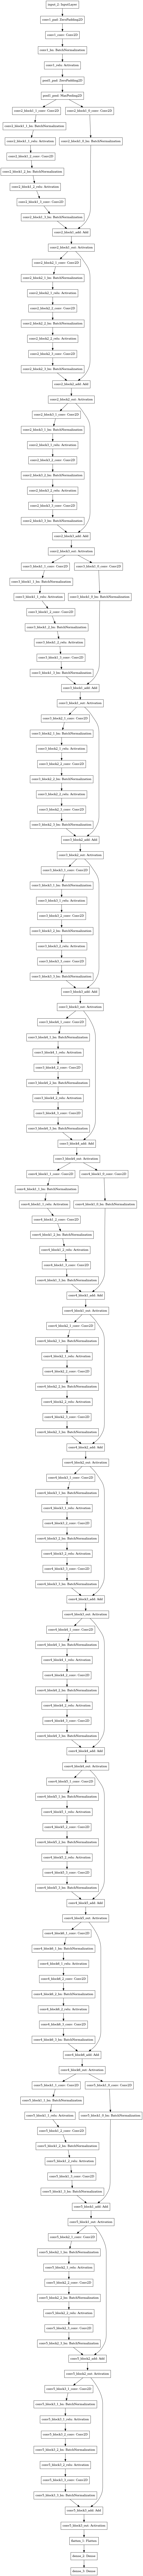

In [36]:
keras.utils.plot_model(resnet_model, "ResNet.png")

In [37]:
resnet_model.fit(x_train,val_train,batch_size=64,epochs=15,validation_data=(x_test,val_test))#batch_size --> 64

2022-12-16 22:26:48.940396: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024192512 exceeds 10% of free system memory.
2022-12-16 22:26:50.068567: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1024192512 exceeds 10% of free system memory.


Epoch 1/15
107/107 [==============================] - 35s 293ms/step - loss: 3.1186 - accuracy: 0.7823 - val_loss: 0.3066 - val_accuracy: 0.8954
Epoch 2/15
107/107 [==============================] - 27s 256ms/step - loss: 0.1328 - accuracy: 0.9544 - val_loss: 0.2770 - val_accuracy: 0.9108
Epoch 3/15
107/107 [==============================] - 27s 253ms/step - loss: 0.0387 - accuracy: 0.9868 - val_loss: 0.2293 - val_accuracy: 0.9294
Epoch 4/15
107/107 [==============================] - 28s 258ms/step - loss: 0.0176 - accuracy: 0.9950 - val_loss: 0.1981 - val_accuracy: 0.9376
Epoch 5/15
107/107 [==============================] - 27s 257ms/step - loss: 0.0075 - accuracy: 0.9988 - val_loss: 0.1790 - val_accuracy: 0.9472
Epoch 6/15
107/107 [==============================] - 27s 256ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.1706 - val_accuracy: 0.9503
Epoch 7/15
107/107 [==============================] - 27s 256ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.1749 - val_ac

In [38]:
resnet_model.evaluate(x_test,val_test) #should be the same as last line in output above

92/92 [==============================] - 10s 95ms/step - loss: 0.1716 - accuracy: 0.9510


[0.17157156765460968, 0.9509602189064026]

I only used VGG and ResNet since I have an intuition about how each of them works , based on this accuracy I will be using and saving the resnet , Now we will be using the test folder to test and get predicitons

### Test Data and the Model

In [39]:
test_data_dir = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST"
test_data_dir = pathlib.Path(test_data_dir)
test_data_dir

PosixPath('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST')

In [40]:
EOSINOPHIL_T = list(test_data_dir.glob('EOSINOPHIL/*'))
LYMPHOCYTE_T= list(test_data_dir.glob('LYMPHOCYTE/*'))
MONOCYTE_T = list(test_data_dir.glob('MONOCYTE/*'))
NEUTROPHIL_T = list(test_data_dir.glob('NEUTROPHIL/*'))

In [41]:
cell_images_dict_Test = {
    'EOSINOPHIL' : EOSINOPHIL_T,
    'LYMPHOCYTE' : LYMPHOCYTE_T,
    'MONOCYTE' : MONOCYTE_T,
    'NEUTROPHIL' : NEUTROPHIL_T
}

In [43]:
x_test,y_test = loadImage(cell_images_dict_Test)


EOSINOPHIL 623
LYMPHOCYTE 620
MONOCYTE 620
NEUTROPHIL 624


In [45]:
x_test = np.array(x_test)
y_test = np.array(y_test)
type(x_test),type(y_test)

(numpy.ndarray, numpy.ndarray)

In [47]:
predictions =resnet_model.predict(x_test)

In [48]:
predictions #shape is like this since I used softmax activation function so each neuron in the dense layer has it's own probability of being the classified image

array([[9.9748021e-01, 6.6006027e-09, 4.0452337e-06, 2.5157814e-03],
       [9.9998605e-01, 2.6583745e-17, 2.8726782e-13, 1.3964237e-05],
       [9.9977511e-01, 6.4048927e-10, 1.6817381e-04, 5.6721678e-05],
       ...,
       [1.0969880e-04, 6.0732372e-21, 1.0543237e-07, 9.9989021e-01],
       [9.9291730e-01, 4.4587506e-14, 2.3699341e-08, 7.0826896e-03],
       [4.1982930e-02, 3.6071723e-13, 8.8090463e-05, 9.5792896e-01]],
      dtype=float32)

In [49]:
# PREDICTIONS
y_pred = []
for i in range(len(predictions)):
    y_pred.append(np.argmax(predictions[i]))
#if we were right the first 623 should be zeros , with expectation of a porportion of errors

In [50]:
y_pred = np.array(y_pred)
print('shape : ', y_pred.shape)
type(y_pred)

shape :  (2426,)


numpy.ndarray

In [58]:
y_test

array([0, 0, 0, ..., 3, 3, 3])

### Classification Metrics:

In [70]:
confusion_matrix(y_pred,y_test)

array([[401,   3,  51, 100],
       [  5, 603,   9,   1],
       [ 11,   5, 455,   4],
       [183,   9,  76, 510]])

In [68]:
print(classification_report(y_test,y_pred))
#     'EOSINOPHIL':0,
#     'LYMPHOCYTE':1,
#     'MONOCYTE':2,
#     'NEUTROPHIL':3

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       600
           1       0.98      0.97      0.97       620
           2       0.96      0.77      0.85       591
           3       0.66      0.83      0.73       615

    accuracy                           0.81      2426
   macro avg       0.83      0.81      0.81      2426
weighted avg       0.83      0.81      0.81      2426



## Saving Model For deployment

In [71]:
model.save("WBBC_model.h5")

Text(87.0, 0.5, 'Truth')

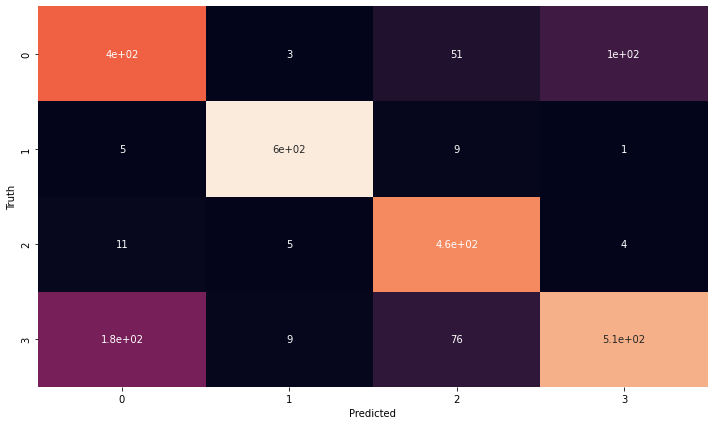

In [64]:
cm1 = confusion_matrix(y_pred,y_test)
plt.figure(figsize=(12,7))
sns.heatmap(cm1,annot=True,cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')